In [44]:
using DataFrames, Statistics, Plots, Measures, CSV

### Zadania
 
1.
 
2. 

3.  Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. **(1 pkt)** Do analizy danych można użyć wybranego narzędzia (Julia, R)

4. Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres. **(1 pkt)**

5. Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ **(1 pkt)**


## Zad1 
Uruchomić 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`) 

    dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależyności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. **(1pkt)**. Do analizy danych można użyć wybranego narzędzia (Julia, R)

In [45]:
# mnożenie macierzy - wersja naiwna
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

naive_multiplication (generic function with 1 method)

In [46]:
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

better_multiplication (generic function with 1 method)

In [47]:
# A*B

In [48]:
df = DataFrame(Nodes=Int[],Naive=Float64[],Better=Float64[], Lib = Float64[])
for n in 5:10:205
    A = rand(n, n);
    B = rand(n, n);
    for j in 1:11
        naive_AB, naive_t = @timed naive_multiplication(A,B)
        better_AB, better_t = @timed better_multiplication(A,B)
        lib_AB, lib_t = @timed A*B
        if j > 1
            push!(df,hcat([n],naive_t, better_t, lib_t))
        end
    end
end

In [49]:
df2 = combine(groupby(df, :Nodes), :Naive => mean, :Better => mean, :Lib => mean, :Naive => std, :Better => std, :Lib => std)
println(df2)

21×7 DataFrame
 Row │ Nodes  Naive_mean  Better_mean  Lib_mean    Naive_std    Better_std   Lib_std     
     │ Int64  Float64     Float64      Float64     Float64      Float64      Float64     
─────┼───────────────────────────────────────────────────────────────────────────────────
   1 │     5  8.5e-7       5.8e-7      9.0e-7      1.77951e-7   6.32456e-8   1.24722e-7
   2 │    15  1.205e-5     5.9e-6      3.43e-6     2.12132e-7   4.66667e-7   6.44722e-7
   3 │    25  5.02e-5      2.068e-5    4.39e-6     2.44404e-6   3.53201e-6   1.26618e-6
   4 │    35  0.0001391    4.915e-5    8.45e-6     3.59104e-6   1.00692e-6   1.1559e-6
   5 │    45  0.00032626   0.00010608  1.788e-5    2.38297e-5   6.91742e-6   4.19809e-6
   6 │    55  0.00073223   0.00023186  3.657e-5    0.000191636  7.37079e-5   1.89541e-5
   7 │    65  0.00101393   0.00030597  0.00037111  4.06239e-5   1.07282e-5   5.19079e-5
   8 │    75  0.0015676    0.00048026  0.00044233  2.52821e-5   3.44608e-5   8.85187e-5
   9 │    85

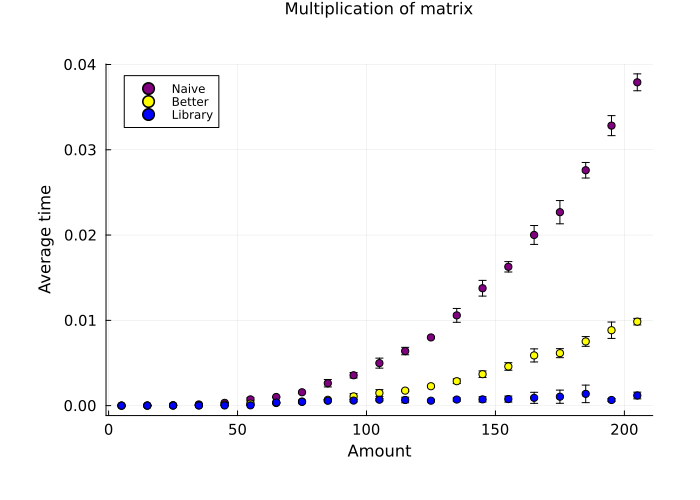

In [50]:
scatter(
    df2.Nodes, 
    size = (700, 500), 
    margin=10mm,
    xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Amount",
    ylabel = "Average time",
    [df2.Naive_mean, df2.Better_mean, df2.Lib_mean], 
    title = "Multiplication of matrix", 
    label = ["Naive"  "Better" "Library"],
    color = [:purple :yellow :blue],
    yerr = [df2.Naive_std df2.Better_std df2.Lib_std], 
    legend = true
)

## ZAD 2
Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy(wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
    Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). **(1 pkt)**
    
    *(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 
Do analizy danych można użyć wybranego narzędzia (Julia, R)

In [51]:
mydata=CSV.read(input, delim=",",DataFrame)
c_data = combine(groupby(mydata,:1),:2 => mean => :m1,:2=> std => :s1, :3 => mean => :m2, :3 => std => :s2, :4 => mean => :m3, :4 => std => :s3)
print(c_data)

51×7 DataFrame
 Row │ size   m1         s1           m2         s2           m3         s3          
     │ Int64  Float64    Float64      Float64    Float64      Float64    Float64     
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │     5  0.0        0.0          0.0        0.0          2.0e-7     6.32456e-7
   2 │    15  2.0e-6     4.46426e-22  2.0e-6     4.46426e-22  2.0e-7     6.32456e-7
   3 │    25  1.04e-5    6.99206e-7   1.56e-5    1.2545e-5    1.0e-6     2.23213e-22
   4 │    35  3.27e-5    1.00006e-5   3.4e-5     1.8625e-5    3.0e-6     4.46426e-22
   5 │    45  6.26e-5    4.22164e-6   6.18e-5    3.64539e-6   6.2e-6     1.13529e-6
   6 │    55  0.0001155  1.09772e-5   0.0001119  4.14863e-6   1.37e-5    8.8198e-6
   7 │    65  0.0001809  2.18327e-6   0.0001823  4.80856e-6   1.81e-5    5.32186e-6
   8 │    75  0.0002781  2.96086e-6   0.0002785  4.32692e-6   2.46e-5    1.26491e-6
   9 │    85  0.0004132  2.08476e-5   0.0004377  4.958

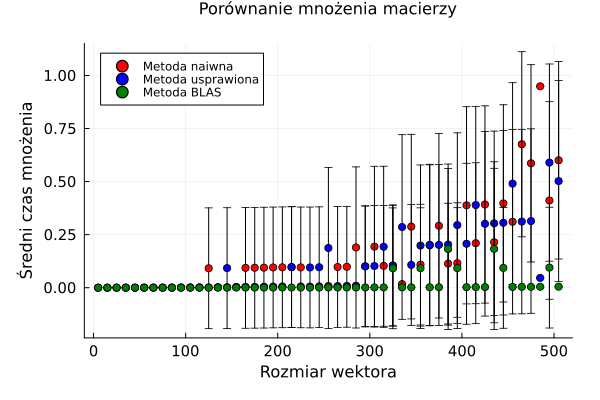

In [52]:
scatter(
    c_data.size, 
    margin=5mm,xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Rozmiar wektora",
    ylabel = "Średni czas mnożenia",
    [c_data.m1,c_data.m2,c_data.m3], 
    title = "Porównanie mnożenia macierzy", 
    legend_position = :topleft, 
    label = ["Metoda naiwna" "Metoda usprawiona" "Metoda BLAS"], 
    color = [:red :blue :green],
    yerr = [c_data.s1 c_data.s2 c_data.s3]
)